In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import numpy as np
import os
import zipfile
import cv2
import matplotlib.pyplot as plt
import time


In [ ]:
# Ekstrak file ZIP
zip_path = '/content/dataset2.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f'File berhasil diekstrak ke {extract_path}')

# Load model segmentasi
segmentation_model = tf.keras.models.load_model('/content/segmentasi_model_unet_best.h5')


File berhasil diekstrak ke /content/


In [ ]:
# Folder dataset
image_dir = '/content/dataset2'
segmented_dir = '/content/dataset2_segmented'
os.makedirs(segmented_dir, exist_ok=True)

SEGMENTATION_IMG_HEIGHT, SEGMENTATION_IMG_WIDTH = 256, 256
PREDICTION_IMG_HEIGHT, PREDICTION_IMG_WIDTH = 224, 224

# Data augmentation settings
data_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

In [ ]:
def segment_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (SEGMENTATION_IMG_HEIGHT, SEGMENTATION_IMG_WIDTH)) / 255.0
    image_input = np.expand_dims(image, axis=0)
    pred_mask = segmentation_model.predict(image_input)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)
    return pred_mask[:, :, 0]  # Mask biner

images = []
labels = []

In [ ]:
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg"):
        img_path = os.path.join(image_dir, filename)
        mask = segment_image(img_path)
        segmented_path = os.path.join(segmented_dir, filename)
        cv2.imwrite(segmented_path, mask * 255)

        # Load segmented image
        img_array = img_to_array(load_img(segmented_path, target_size=(PREDICTION_IMG_HEIGHT, PREDICTION_IMG_WIDTH))) / 255.0
        label = int(filename.split('.')[0])

        # Tambahkan gambar asli
        images.append(img_array.astype(np.float32))
        labels.append(label)

        # Augmentasi sebanyak 3 kali
        img_array_expanded = np.expand_dims(img_array, axis=0)
        augmented_images = data_gen.flow(img_array_expanded, batch_size=1)

        for _ in range(2):
            aug_img = next(augmented_images)[0]  # Ambil batch pertama
            images.append(aug_img.astype(np.float32))
            labels.append(label)

X = np.array(images)
y = np.array(labels, dtype=np.float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
# Model dengan arsitektur baru
model = tf.keras.Sequential([
    # Blok 1
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Blok 2
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Blok 3
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Blok 4
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),

    # Fully Connected Layer
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    # Output Layer untuk regresi
    tf.keras.layers.Dense(1, activation='linear')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Fungsi custom RMSE
def rmse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.sqrt(tf.keras.backend.mean(tf.square(y_true - y_pred)))

# Compile model dengan RMSE
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae', rmse]
)

# Callback untuk menyimpan model terbaik
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Mulai hitung waktu training
start_time = time.time()

# Training model
history = model.fit(
    X, y,
    epochs=750,
    batch_size=32,
    callbacks=[checkpoint]
)

# Selesai hitung waktu training
end_time = time.time()
training_time = end_time - start_time
print(f"Waktu training: {training_time:.2f} detik")

Epoch 1/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 232759.1562 - mae: 427.0706 - rmse: 475.3237
Epoch 1: loss improved from inf to 220952.75000, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 228823.6875 - mae: 422.7750 - rmse: 468.8476
Epoch 2/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 130070.1875 - mae: 283.9856 - rmse: 357.4969
Epoch 2: loss improved from 220952.75000 to 124406.42969, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 128182.2656 - mae: 280.7648 - rmse: 353.1840
Epoch 3/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 64004.8750 - mae: 200.3256 - rmse: 273.3399
Epoch 3: loss improved from 124406.42969 to 58916.83984, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 62308.8633 - mae: 197.8180 - rmse: 272.3138
Epoch 4/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 55640.4258 - mae: 195.7301 - rmse: 280.1772
Epoch 4: loss improved from 58916.83984 to 57431.92188, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 56237.5898 - mae: 196.6283 - rmse: 284.6127
Epoch 5/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 64132.0078 - mae: 216.9267 - rmse: 262.3463
Epoch 5: loss did not improve from 57431.92188
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 63136.6367 - mae: 214.7406 - rmse: 258.5200
Epoch 6/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 72944.7969 - mae: 184.2198 - rmse: 264.9745
Epoch 6: loss did not improve from 57431.92188
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 71066.2969 - mae: 182.9417 - rmse: 259.8397
Epoch 7/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 72336.1953 - mae: 197.5730 - rmse: 275.5178
Epoch 7: loss did not improve from 57431.92188
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 69604.5781 - mae: 194.0817 - rmse: 266.8570
Epoch 8/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 44537.5703 - mae: 161.2940 - rmse: 250.0306
Epoch 8: loss improved from 57431.92188 to 41954.58984, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 43676.5781 - mae: 161.5691 - rmse: 245.5286
Epoch 9/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 34787.8438 - mae: 152.8322 - rmse: 249.6639
Epoch 9: loss improved from 41954.58984 to 33010.73828, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 34195.4727 - mae: 152.4162 - rmse: 255.6823
Epoch 10/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 40173.0312 - mae: 163.2504 - rmse: 257.3384
Epoch 10: loss did not improve from 33010.73828
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 40004.4336 - mae: 160.9755 - rmse: 255.4128
Epoch 11/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 34111.2773 - mae: 151.7590 - rmse: 250.3368
Epoch 11: loss did not improve from 33010.73828
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 35703.3359 - mae: 154.2965 - rmse: 254.7303
Epoch 12/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 37325.2578 - mae: 140.5586 - rmse: 252.2256
Epoch 12: loss did not improve from 33010.73828
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 36278.3320 - mae: 139.0460 - rmse: 257.5511
Epoch 13/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 34257.1172 - mae: 135.9891 - rmse: 276.5864
Epoch 13: loss improved from 33010.73828 to 32538.63086, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 33684.2891 - mae: 135.0712 - rmse: 276.6796
Epoch 14/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 19643.3906 - mae: 113.7228 - rmse: 279.7499
Epoch 14: loss improved from 32538.63086 to 19483.42969, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 19590.0703 - mae: 113.7542 - rmse: 281.1897
Epoch 15/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 25211.9844 - mae: 125.5328 - rmse: 282.1061
Epoch 15: loss did not improve from 19483.42969
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 25146.6270 - mae: 124.2695 - rmse: 283.9737
Epoch 16/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 23979.0469 - mae: 113.6799 - rmse: 267.6994
Epoch 16: loss did not improve from 19483.42969
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 24067.8008 - mae: 114.7184 - rmse: 272.3822
Epoch 17/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 16667.8828 - mae: 98.9114 - rmse: 302.4113 
Epoch 17: loss improved from 19483.42969 to 15048.98438, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 16128.2510 - mae: 97.6818 - rmse: 305.0617
Epoch 18/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 19011.0352 - mae: 109.4589 - rmse: 300.4563
Epoch 18: loss did not improve from 15048.98438
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 18867.3184 - mae: 108.5392 - rmse: 299.4925
Epoch 19/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 16945.9727 - mae: 98.5105 - rmse: 307.0323
Epoch 19: loss did not improve from 15048.98438
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 17725.6484 - mae: 101.2407 - rmse: 310.4529
Epoch 20/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 13134.2715 - mae: 85.9052 - rmse: 299.4079
Epoch 20: loss improved from 15048.98438 to 12524.19434, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 12930.9131 - mae: 84.9136 - rmse: 284.7433
Epoch 21/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 18035.2148 - mae: 103.4119 - rmse: 317.5994
Epoch 21: loss did not improve from 12524.19434
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 17967.7207 - mae: 103.0614 - rmse: 310.7321
Epoch 22/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 15748.3232 - mae: 97.5156 - rmse: 326.6290 
Epoch 22: loss did not improve from 12524.19434
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 15230.8545 - mae: 95.8124 - rmse: 311.3775
Epoch 23/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 8637.2520 - mae: 71.0638 - rmse: 328.2764
Epoch 23: loss improved from 12524.19434 to 7994.04102, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 8422.8477 - mae: 70.4225 - rmse: 327.6653
Epoch 24/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 11460.1660 - mae: 81.0443 - rmse: 318.9913
Epoch 24: loss did not improve from 7994.04102
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 11853.3623 - mae: 81.9833 - rmse: 320.2545
Epoch 25/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 11431.0215 - mae: 83.8506 - rmse: 298.0967
Epoch 25: loss did not improve from 7994.04102
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 11066.7266 - mae: 82.6133 - rmse: 290.9534
Epoch 26/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 10916.4072 - mae: 77.2419 - rmse: 303.4298
Epoch 26: loss did not improve from 7994.04102
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 11838.2393 - mae: 79.7707 - rmse: 308.0664
Epoch 27/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 11668.0869 - mae: 84.3201 - rmse: 285.5490
Epoch 27: loss did not improve from 7994.04102
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 11716.0879 - mae: 84.

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 7303.5952 - mae: 68.4868 - rmse: 290.3946
Epoch 44/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 11624.3789 - mae: 84.1137 - rmse: 282.4128
Epoch 44: loss did not improve from 6862.39648
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 12153.6074 - mae: 84.7626 - rmse: 289.6461
Epoch 45/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 10369.7031 - mae: 78.4173 - rmse: 315.4026
Epoch 45: loss did not improve from 6862.39648
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 10331.5000 - mae: 78.4396 - rmse: 316.6576
Epoch 46/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 17060.2695 - mae: 99.5483 - rmse: 292.7337 
Epoch 46: loss did not improve from 6862.39648
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 16949.6387 - mae: 99.2009 - rmse: 301.6769
Epoch 47/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 12578.1807 - mae: 87.9316 - rmse: 282.9795
Epoch 47: loss did not improve from 6862.39648
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 13297.6152 - mae: 89

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 7239.9194 - mae: 60.4346 - rmse: 312.0143
Epoch 50/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 12509.0859 - mae: 90.3510 - rmse: 305.2738
Epoch 50: loss did not improve from 6637.32373
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 12346.7236 - mae: 89.5686 - rmse: 289.1960
Epoch 51/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 19212.6641 - mae: 98.8712 - rmse: 369.8031 
Epoch 51: loss did not improve from 6637.32373
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 18918.2852 - mae: 97.8101 - rmse: 362.8514
Epoch 52/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 13275.8535 - mae: 80.2410 - rmse: 345.7378
Epoch 52: loss did not improve from 6637.32373
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 12755.8955 - mae: 78.6047 - rmse: 336.4135
Epoch 53/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 9570.9658 - mae: 73.9790 - rmse: 346.9942
Epoch 53: loss did not improve from 6637.32373
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 10090.8545 - mae: 75.

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 6337.5796 - mae: 60.4457 - rmse: 321.0419
Epoch 129/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 6776.5381 - mae: 64.3367 - rmse: 331.4996
Epoch 129: loss did not improve from 6052.31055
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 7043.8701 - mae: 65.9907 - rmse: 332.6607
Epoch 130/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 11840.3770 - mae: 90.1889 - rmse: 318.9171
Epoch 130: loss did not improve from 6052.31055
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 12077.1875 - mae: 90.6941 - rmse: 318.9875
Epoch 131/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 12327.0430 - mae: 81.7385 - rmse: 295.9070
Epoch 131: loss did not improve from 6052.31055
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 12144.6162 - mae: 81.0872 - rmse: 300.9035
Epoch 132/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 11595.6855 - mae: 80.6741 - rmse: 293.1793
Epoch 132: loss did not improve from 6052.31055
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 11431.7109 - ma

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 4734.4629 - mae: 46.4413 - rmse: 328.6838
Epoch 154/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 8201.3408 - mae: 66.1616 - rmse: 335.6998
Epoch 154: loss did not improve from 4611.95752
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 8010.6675 - mae: 65.7677 - rmse: 325.4782
Epoch 155/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4195.7891 - mae: 55.9685 - rmse: 302.4541
Epoch 155: loss improved from 4611.95752 to 4175.67334, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 4189.0840 - mae: 55.7155 - rmse: 311.9640
Epoch 156/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 7234.6978 - mae: 69.5915 - rmse: 294.4738
Epoch 156: loss did not improve from 4175.67334
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 7180.0220 - mae: 69.2658 - rmse: 303.5979
Epoch 157/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 5854.3940 - mae: 57.4776 - rmse: 297.2523
Epoch 157: loss did not improve from 4175.67334
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 5644.8374 - mae: 56.6593 - rmse: 299.0722
Epoch 158/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 5975.8540 - mae: 58.6973 - rmse: 296.8771
Epoch 158: loss did not improve from 4175.67334
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 6007.9224 - mae: 58.9698 - rmse: 296.5083
Epoch 159/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 9629.7402 - mae: 71.4389 - rmse: 305.9669
Epoch 159: loss did not improve from 4175.67334
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 10170.3711 - mae: 72

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 4314.0986 - mae: 51.4725 - rmse: 310.0280
Epoch 278/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 5059.4453 - mae: 53.4783 - rmse: 324.4944
Epoch 278: loss did not improve from 4013.15625
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 5142.9712 - mae: 54.0503 - rmse: 317.0418
Epoch 279/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 6380.5527 - mae: 55.2623 - rmse: 318.6136
Epoch 279: loss did not improve from 4013.15625
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 6741.5215 - mae: 56.1532 - rmse: 323.9898
Epoch 280/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 8931.4023 - mae: 71.2615 - rmse: 338.0808
Epoch 280: loss did not improve from 4013.15625
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 8788.1338 - mae: 70.8899 - rmse: 341.7873
Epoch 281/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 6355.5576 - mae: 58.7827 - rmse: 309.3441
Epoch 281: loss did not improve from 4013.15625
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 6311.2349 - mae: 58.

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 4185.7505 - mae: 52.3279 - rmse: 309.9519
Epoch 454/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 7428.3174 - mae: 67.2894 - rmse: 326.4924
Epoch 454: loss did not improve from 4013.10181
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 7310.8032 - mae: 66.9217 - rmse: 320.3539
Epoch 455/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 8562.1240 - mae: 66.0338 - rmse: 303.9200
Epoch 455: loss did not improve from 4013.10181
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 8559.8623 - mae: 65.8522 - rmse: 296.3387
Epoch 456/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 5791.3101 - mae: 54.5308 - rmse: 293.4393
Epoch 456: loss did not improve from 4013.10181
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 6297.7700 - mae: 55.2540 - rmse: 296.0622
Epoch 457/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 6532.5991 - mae: 61.9983 - rmse: 317.3349
Epoch 457: loss did not improve from 4013.10181
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 6496.0806 - mae: 62.

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 3735.6707 - mae: 50.4369 - rmse: 306.5063
Epoch 494/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 7751.9893 - mae: 65.9685 - rmse: 299.7347
Epoch 494: loss did not improve from 3767.87793
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 7711.8979 - mae: 65.8098 - rmse: 305.5766
Epoch 495/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 9551.3896 - mae: 67.3272 - rmse: 329.3898
Epoch 495: loss did not improve from 3767.87793
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 10175.4463 - mae: 68.6044 - rmse: 332.6703
Epoch 496/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 5231.7954 - mae: 54.9039 - rmse: 312.2888
Epoch 496: loss did not improve from 3767.87793
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 5361.3506 - mae: 56.0501 - rmse: 311.2243
Epoch 497/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 8319.2383 - mae: 70.4560 - rmse: 298.4460
Epoch 497: loss did not improve from 3767.87793
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 7910.1714 - mae: 68

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 3043.0049 - mae: 42.3172 - rmse: 308.7189
Epoch 520/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 8204.2949 - mae: 62.9047 - rmse: 316.5740
Epoch 520: loss did not improve from 3245.09644
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 8271.5430 - mae: 63.3947 - rmse: 324.6791
Epoch 521/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 5565.4897 - mae: 55.4278 - rmse: 322.5790
Epoch 521: loss did not improve from 3245.09644
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 5573.2158 - mae: 55.6959 - rmse: 327.1218
Epoch 522/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 7717.4731 - mae: 64.3813 - rmse: 336.2964
Epoch 522: loss did not improve from 3245.09644
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 7448.6558 - mae: 63.1793 - rmse: 328.5701
Epoch 523/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 9275.6641 - mae: 57.5802 - rmse: 336.3742
Epoch 523: loss did not improve from 3245.09644
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 9074.7764 - mae: 57.

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 3203.1101 - mae: 45.4347 - rmse: 299.8756
Epoch 569/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 19951.2695 - mae: 88.9129 - rmse: 357.3119
Epoch 569: loss did not improve from 3091.64478
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 18895.1230 - mae: 85.9932 - rmse: 334.4397
Epoch 570/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 5955.3267 - mae: 59.0032 - rmse: 301.3388
Epoch 570: loss did not improve from 3091.64478
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 5958.7100 - mae: 59.0278 - rmse: 313.7631
Epoch 571/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 10582.7754 - mae: 76.7331 - rmse: 299.8561
Epoch 571: loss did not improve from 3091.64478
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 10498.5225 - mae: 75.6694 - rmse: 296.1724
Epoch 572/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 12234.6016 - mae: 75.5157 - rmse: 327.3059
Epoch 572: loss did not improve from 3091.64478
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 11716.3545 - m

File berhasil diekstrak ke /content/


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


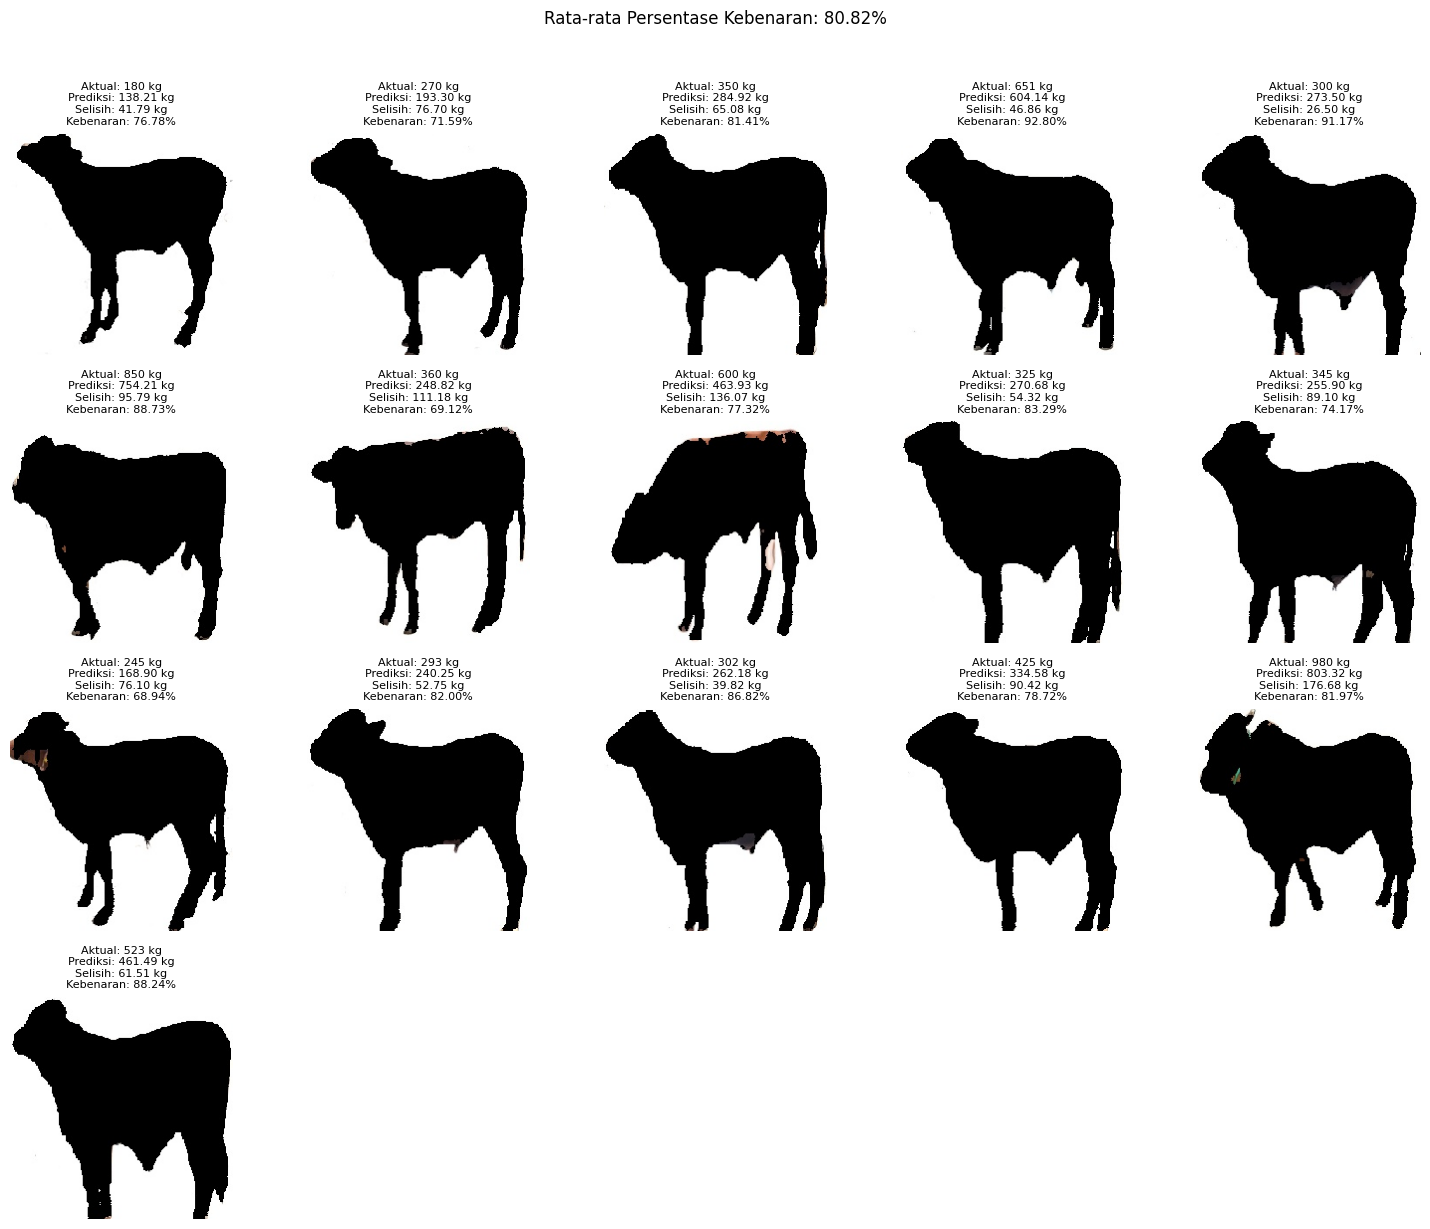

In [ ]:
import zipfile
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import math
import cv2

# Ekstrak file ZIP test
test_zip_path = '/content/dataset2.zip'
test_extract_path = '/content/'

with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(test_extract_path)

print(f'File berhasil diekstrak ke {test_extract_path}')

# Load model segmentasi
segmentation_model = tf.keras.models.load_model('/content/segmentasi_model_unet_best.h5')

# Folder dataset
test_image_dir = '/content/dataset2'
test_segmented_dir = '/content/dataset2_segmented'
os.makedirs(test_segmented_dir, exist_ok=True)

SEGMENTATION_IMG_HEIGHT, SEGMENTATION_IMG_WIDTH = 256, 256
PREDICTION_IMG_HEIGHT, PREDICTION_IMG_WIDTH = 224, 224

def segment_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (SEGMENTATION_IMG_WIDTH, SEGMENTATION_IMG_HEIGHT)) / 255.0
    image_input = np.expand_dims(image, axis=0)
    pred_mask = segmentation_model.predict(image_input)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    segmented_image = image * np.expand_dims(pred_mask[:, :, 0], axis=-1)
    return segmented_image

images = []
labels = []

for filename in os.listdir(test_image_dir):
    if filename.endswith(".jpg"):
        img_path = os.path.join(test_image_dir, filename)
        segmented_image = segment_image(img_path)
        segmented_path = os.path.join(test_segmented_dir, filename)
        cv2.imwrite(segmented_path, cv2.cvtColor((segmented_image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

        img_array = img_to_array(load_img(segmented_path, target_size=(PREDICTION_IMG_HEIGHT, PREDICTION_IMG_WIDTH))) / 255.0
        label = int(filename.split('.')[0])

        images.append(img_array)
        labels.append(label)

X = np.array(images)
y = np.array(labels)

# Load model prediksi bobot sapi
best_model = tf.keras.models.load_model('best_model.h5')
prediksi_bobot = best_model.predict(X)
selisih = np.abs(y - prediksi_bobot.flatten())
persentase_kebenaran = 100 * (1 - selisih / y)
rata_rata_persentase = np.mean(persentase_kebenaran)

num_images = len(X)
cols = 5
rows = math.ceil(num_images / cols)

plt.figure(figsize=(cols * 3, rows * 3))

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(X[i])
    plt.axis('off')
    plt.title(f"Aktual: {y[i]} kg\nPrediksi: {prediksi_bobot[i][0]:.2f} kg\nSelisih: {selisih[i]:.2f} kg\nKebenaran: {persentase_kebenaran[i]:.2f}%", fontsize=8, color='black')

plt.suptitle(f"Rata-rata Persentase Kebenaran: {rata_rata_persentase:.2f}%", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

File berhasil diekstrak ke /content/


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


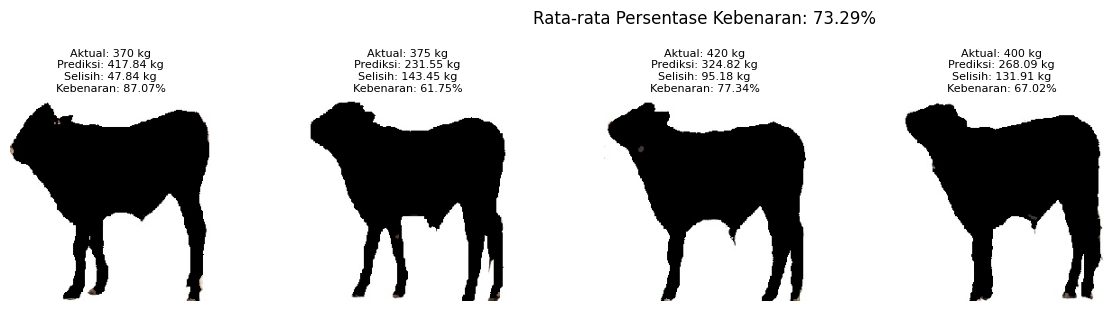

In [ ]:
import zipfile
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import math
import cv2

# Ekstrak file ZIP test
test_zip_path = '/content/test.zip'
test_extract_path = '/content/'

with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(test_extract_path)

print(f'File berhasil diekstrak ke {test_extract_path}')

# Load model segmentasi
segmentation_model = tf.keras.models.load_model('/content/segmentasi_model_unet_best.h5')

# Folder dataset
test_image_dir = '/content/test'
test_segmented_dir = '/content/test_segmented'
os.makedirs(test_segmented_dir, exist_ok=True)

SEGMENTATION_IMG_HEIGHT, SEGMENTATION_IMG_WIDTH = 256, 256
PREDICTION_IMG_HEIGHT, PREDICTION_IMG_WIDTH = 224, 224

def segment_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (SEGMENTATION_IMG_WIDTH, SEGMENTATION_IMG_HEIGHT)) / 255.0
    image_input = np.expand_dims(image, axis=0)
    pred_mask = segmentation_model.predict(image_input)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    segmented_image = image * np.expand_dims(pred_mask[:, :, 0], axis=-1)
    return segmented_image

images = []
labels = []

for filename in os.listdir(test_image_dir):
    if filename.endswith(".jpg"):
        img_path = os.path.join(test_image_dir, filename)
        segmented_image = segment_image(img_path)
        segmented_path = os.path.join(test_segmented_dir, filename)
        cv2.imwrite(segmented_path, cv2.cvtColor((segmented_image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

        img_array = img_to_array(load_img(segmented_path, target_size=(PREDICTION_IMG_HEIGHT, PREDICTION_IMG_WIDTH))) / 255.0
        label = int(filename.split('.')[0])

        images.append(img_array)
        labels.append(label)

X = np.array(images)
y = np.array(labels)

# Load model prediksi bobot sapi
best_model = tf.keras.models.load_model('best_model.h5')
prediksi_bobot = best_model.predict(X)
selisih = np.abs(y - prediksi_bobot.flatten())
persentase_kebenaran = 100 * (1 - selisih / y)
rata_rata_persentase = np.mean(persentase_kebenaran)

num_images = len(X)
cols = 5
rows = math.ceil(num_images / cols)

plt.figure(figsize=(cols * 3, rows * 3))

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(X[i])
    plt.axis('off')
    plt.title(f"Aktual: {y[i]} kg\nPrediksi: {prediksi_bobot[i][0]:.2f} kg\nSelisih: {selisih[i]:.2f} kg\nKebenaran: {persentase_kebenaran[i]:.2f}%", fontsize=8, color='black')

plt.suptitle(f"Rata-rata Persentase Kebenaran: {rata_rata_persentase:.2f}%", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

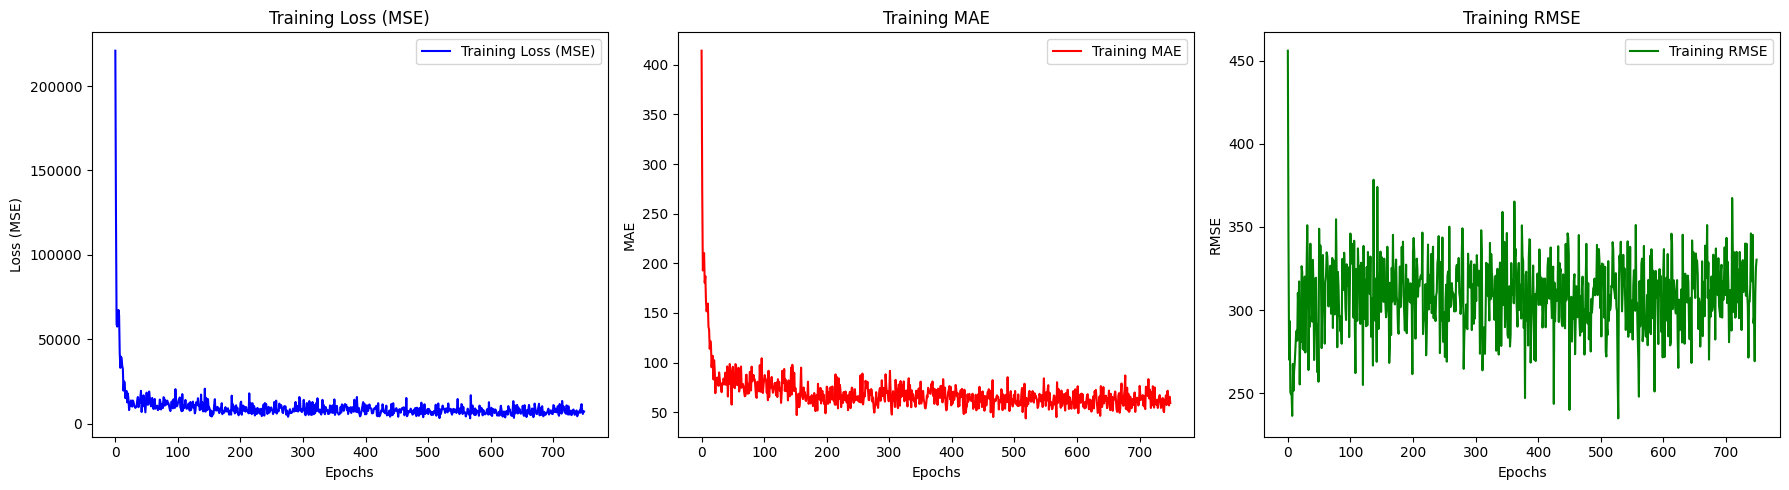

In [ ]:
plt.figure(figsize=(18, 5))

# Plot Loss (MSE)
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss (MSE)', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss (MSE)')
plt.legend()

# Plot Mean Absolute Error (MAE)
plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Training MAE', color='red')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training MAE')
plt.legend()

# Plot Root Mean Squared Error (RMSE)
plt.subplot(1, 3, 3)
plt.plot(history.history['rmse'], label='Training RMSE', color='green')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training RMSE')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Ambil nilai MAE dan RMSE dari history
mae_values = history.history['mae']
rmse_values = history.history['rmse']

min_mae_index = mae_values.index(min(mae_values))

min_mae = mae_values[min_mae_index]
corresponding_rmse = rmse_values[min_mae_index]

print(f"MAE terkecil: {min_mae:.4f} pada epoch {min_mae_index + 1}")
print(f"RMSE pada epoch yang sama: {corresponding_rmse:.4f}")

MAE terkecil: 43.7697 pada epoch 519
RMSE pada epoch yang sama: 313.9459
